# Traffic Balancer

This notebook is used to implement loss minimization techniques for traffic balancing in a network.

## Goals:
- Implement a traffic balancer that minimizes the loss in a network, given a loss function.
- Implement stochastic gradient descent to minimize the loss function.
- Implemenet constraints

## Import the Graph

In [2]:
#the graph is stored as a pickle file, in a file called 'graph.gpickle'
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from collections import deque
import seaborn as sns
from tqdm import tqdm
import pickle

In [3]:
#read the graph from the file
#each code is a differeent graph with different starting conditions
# 1 - random graph
# 2 - linearly flow balanced graph
code = 1
with open('graph' + str(code) + '.gpickle', 'rb') as f:
    G = pickle.load(f)

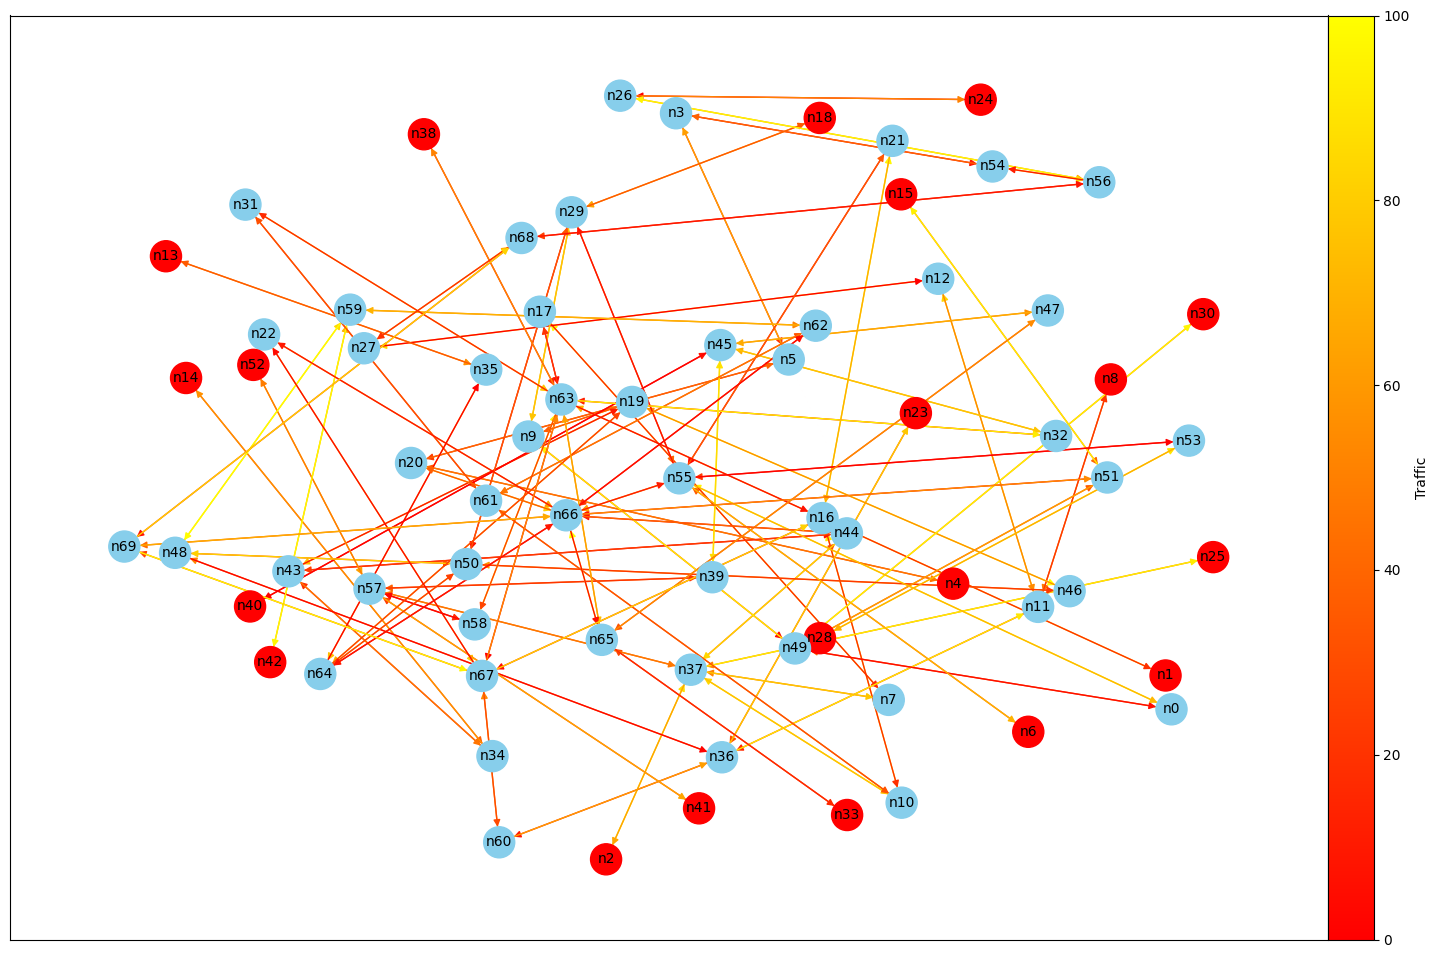

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming you have already defined G and pos

# Draw the graph
plt.figure(figsize=(20, 12))
# Create a colormap that is the second half of the copper colormap

pos = nx.spring_layout(G, k=0.5, iterations=20)
cmap = plt.cm.autumn
# Draw the network with node colors and edge colors
nx.draw_networkx(G, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G.edges[edge]['traffic'] for edge in G.edges], edge_cmap=cmap, pos=pos)

# Get the current Axes instance
ax = plt.gca()

# Create a ScalarMappable to map numerical values to colors in the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min([G.edges[edge]['traffic'] for edge in G.edges]), vmax=max([G.edges[edge]['traffic'] for edge in G.edges])))

# Empty array to hold the values for the color bar
sm.set_array([])

# Add the color bar at the bottom of the plot
plt.colorbar(sm, ax=ax, label='Traffic', pad=-0, orientation='vertical')

# Show the plot
plt.show()


## Loss Functions

- We have 4 kinds of loss functions, and each are applied at different scales, and differ on what they are applied to.
    - Node Loss Function: The loss function for a single node
    - Global Node Loss Function: The loss function for the entire network
    - Edge Loss Function: The loss function for a single edge
    - Global Edge Loss Function: The loss function for the entire network
- Node Loss Functions are applied to a single node:
- Edge Loss Functions are applied to a single edge, and really only have one type of structure:
  - Two-Way Traffic Disparity: This loss functions represents the fact that ideally, edges have equal traffic in both directions.
- Global Node Loss Functions are applied to the entire network, and are weighted by total traffic at a node to make larger nodes more important.
- Global Edge Loss Functions are applied to the entire network, and are weighted by total traffic on an edge to make larger edges more important.

In [5]:
#Lets define our node loss function
#Loss can be measured as the standard deviation of the traffic values flowing out of the node, into the node, or both
#we will define the function with a parameter 'direction' which can be 'in', 'out', or 'both'
def nodeLoss(G,node, direction):
    #if an edge has 4 lanes, then it needs to repeat the traffic value 4 times when calculating the standard deviation
    #so we will create a list of traffic values for each edge, and then flatten the list
    if direction == 'in':
        traffic = [G.edges[edge]['traffic'] for edge in G.in_edges(node) for i in range(G.edges[edge]['lanes'])]
    elif direction == 'out':
        traffic = [G.edges[edge]['traffic'] for edge in G.out_edges(node) for i in range(G.edges[edge]['lanes'])]
    elif direction == 'both':
        traffic = [G.edges[edge]['traffic'] for edge in G.in_edges(node) for i in range(G.edges[edge]['lanes'])] + [G.edges[edge]['traffic'] for edge in G.out_edges(node) for i in range(G.edges[edge]['lanes'])]
    else:
        raise ValueError('direction must be in, out, or both')
    #return both the standard deviation and the total traffic
    return np.std(traffic)

In [6]:

#Lets define our edge loss function
#Loss can be measured as the absolute difference between the traffic values flowing out of the edge and the traffic values flowing into the edge
def edgeLoss(G, edge):
    u,v = edge
    #return both the absolute difference and the total traffic
    return abs(G.edges[u,v]['traffic'] - G.edges[v,u]['traffic']), G.edges[u,v]['traffic'] + G.edges[v,u]['traffic']

In [7]:
#lets define a function to calculate the total loss of the graph
def totalNodeLoss(G):
    #take the weighted sum of the node loss of all the nodes, weighted by the total traffic flowing through the node
    return np.sum([(nodeLoss(G, node, 'both') * G.nodes[node]['traffic'])for node in G.nodes])

def totalEdgeLoss(G):
    #take the weighted sum of the edge loss of all the edges, weighted by the total traffic flowing through the edge
    return np.sum([(edgeLoss(G, edge)[0] * edgeLoss(G, edge)[1]) for edge in G.edges])
    #technically, the edge loss is the same for both directions, so we can just take the average of the edge loss of all the edges

def totalTraffic(G):
    #sum up the traffic of all the edges
    return np.sum([G.edges[edge]['traffic'] * G.edges[edge]['lanes'] for edge in G.edges])

In [8]:
print('Total node loss:', totalNodeLoss(G))
print('Total edge loss:', totalEdgeLoss(G))
print('Total traffic:', totalTraffic(G))

Total node loss: 1076030.8424852653
Total edge loss: 630508.0
Total traffic: 20458.0


## Loss Function Gradients

In [9]:
#we want to calculate the gradient for each traffic value in the graph
#we are going to do this by looking at the change in node loss when we change the traffic value by a small amount on the 2 nodes that the edge connects
#we will return the gradient that minimizes the total node loss

#lets define a function to calculate the gradient for a single edge
def edgeGradient(G, edge, epsilon=1):
    #we will pertiurb the traffic in both directions by a small amount, and calcaulte the change in node loss on both nodes

    #first, we will calculate the node loss on both nodes
    node1 = edge[0]
    node2 = edge[1]
    node1Loss = nodeLoss(G, node1, 'both')
    node2Loss = nodeLoss(G, node2, 'both')

    #then, we will perturb the traffic on the edge in both directions
    #first, lets find the positive perturbation
    G.edges[edge]['traffic'] += epsilon
    #find the new node loss on both nodes
    node1LossPos = nodeLoss(G, node1, 'both')
    node2LossPos = nodeLoss(G, node2, 'both')
    f_plus = node1LossPos + node2LossPos - node1Loss - node2Loss
    #then, lets find the negative perturbation
    G.edges[edge]['traffic'] -= 2 * epsilon
    #find the new node loss on both nodes
    node1LossNeg = nodeLoss(G, node1, 'both')
    node2LossNeg = nodeLoss(G, node2, 'both')
    f_minus = node1LossNeg + node2LossNeg - node1Loss - node2Loss
    #then, lets find the gradient
    return (f_plus - f_minus) / (2 * epsilon)


#lets define a function to calculate the gradient for the entire graph
def graphGradient(G, epsilon=1):
    #calculate the gradient for each edge
    epsilon = random.uniform(-epsilon, epsilon)
    gradients = [edgeGradient(G, edge, epsilon) for edge in G.edges]
    return gradients


In [10]:
#test the gradient function
print('Gradient:', graphGradient(G))

Gradient: [0.47474245017745886, -0.13854956162323115, 0.6231056470013617, 0.5374810657522395, -0.44968128217245806, -0.6643419904227503, -0.6661227296592014, 0.9115397767446586, -0.207535951625916, -0.49195868399738724, 0.819012659204762, -0.07685636126454475, 0.5219064795123619, 0.21858363865411487, 0.005505009862948039, -0.5628801413943109, 0.017263337776741727, 0.20223206796802998, 0.2656914649889324, -0.7040923066670741, -0.3708901062663011, 0.19817233763114062, 0.028054061496049686, 0.49389103821537683, 0.6302654854528458, -0.5437161683831953, -0.5069057347301644, -0.6319868258993782, -0.2845102657417715, -0.13725668664909177, 0.4721659722279461, 0.09129962354773355, -0.5579867455465544, -0.3099246744402683, 0.5624387075967799, -0.12175943062800756, 0.6128592911224431, 0.577716956343008, 0.136230379001271, 0.5716440241867496, -0.01216762556492995, 0.35687058137309774, 0.16947342115465608, -0.42396031409775725, 0.2671362123266208, 0.439200504401139, -0.5563236968225157, -0.87568966

Edge: ('n63', 'n58')
Traffic: 26.10811180779267
Node 1: n63 Node 2: n58
Node 1 traffic: 1795.0 Node 2 traffic: 141.0


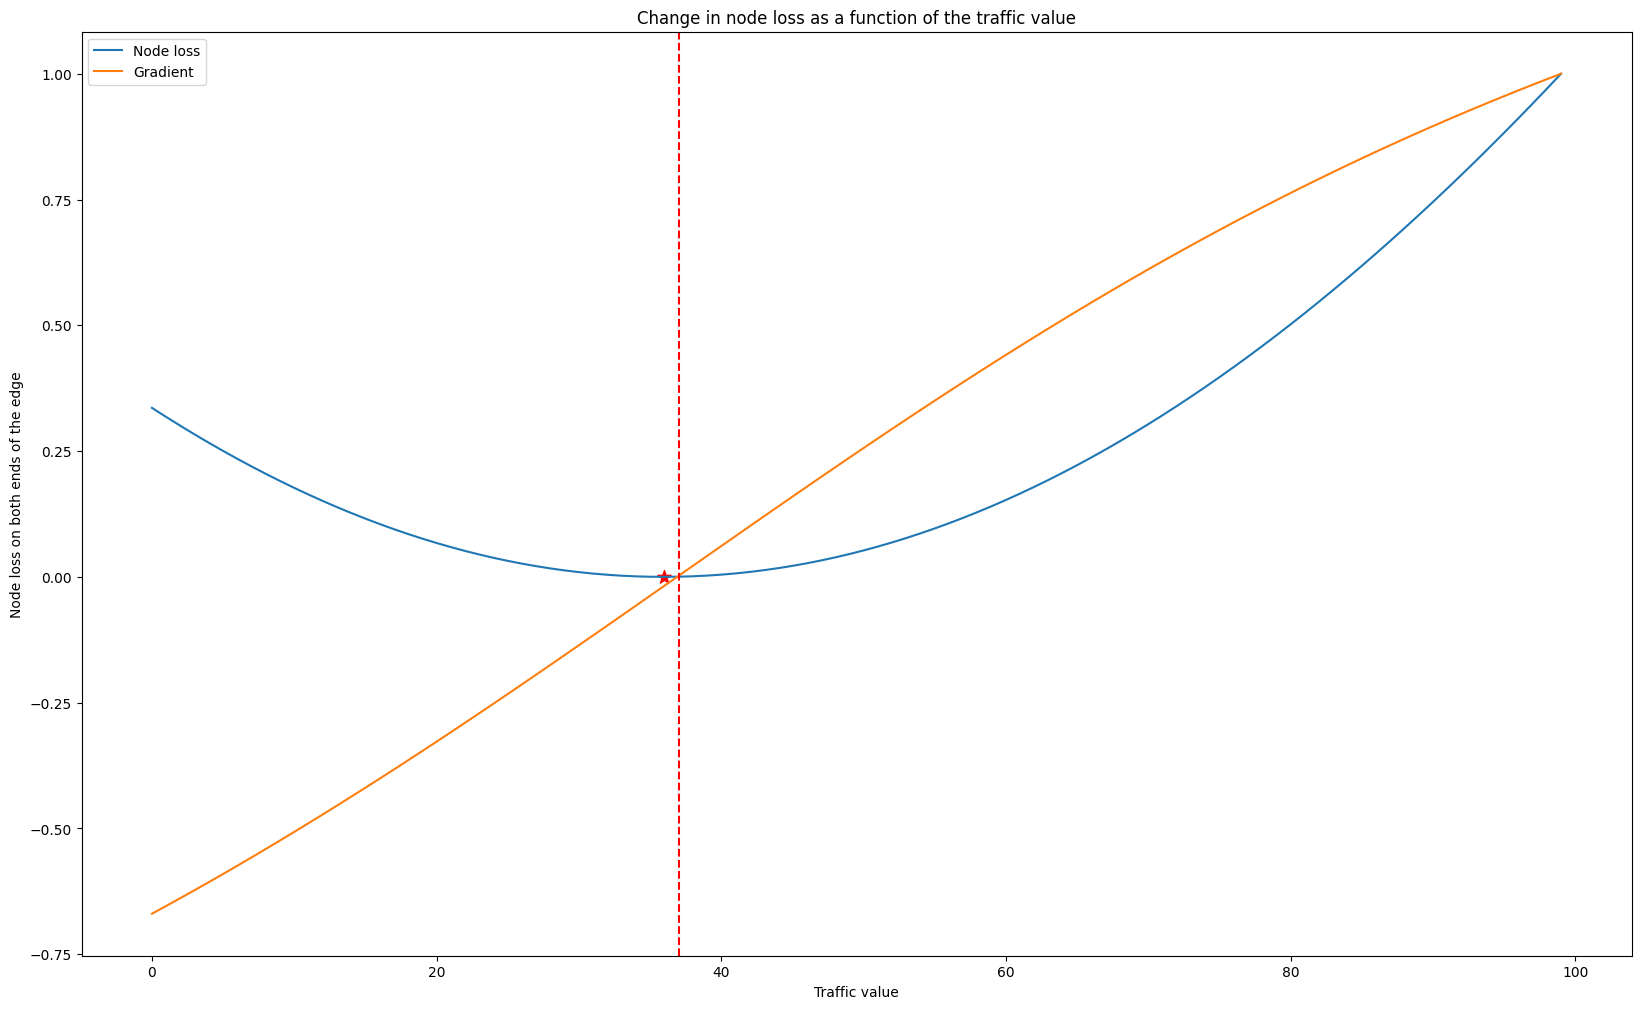

In [11]:
#pick a random edge, and simulate the change in node loss as we change the traffic value over a range of values
edge = random.choice(list(G.edges))
print('Edge:', edge)
print('Traffic:', G.edges[edge]['traffic'])
print('Node 1:', edge[0], 'Node 2:', edge[1])
print('Node 1 traffic:', G.nodes[edge[0]]['traffic'], 'Node 2 traffic:', G.nodes[edge[1]]['traffic'])

#try 100 different values, and calculate the change in node loss for each value
#we will plot the change in node loss as a function of the traffic value
#we will also plot the gradient as a function of the traffic value

losses = []
gradients = []
originalTraffic = G.edges[edge]['traffic']

for i in range(100):
    #perturb the traffic value
    G.edges[edge]['traffic'] = i
    #calculate the node loss
    losses.append((nodeLoss(G, edge[0], 'both') * G.nodes[edge[0]]['traffic'] + nodeLoss(G, edge[1], 'both') * G.nodes[edge[1]]['traffic'] ))
    #calculate the gradient
    gradients.append(edgeGradient(G, edge, 0.5))

#reset the traffic value
G.edges[edge]['traffic'] = originalTraffic

#standardize the losses and gradients so that they are between 0 and 1
losses = (losses - np.min(losses)) / (np.max(losses) - np.min(losses))
gradients = gradients / np.max(np.abs(gradients))

#plot the change in node loss as a function of the traffic value
plt.figure(figsize=(20, 12))
plt.plot(range(100), losses)
plt.plot(range(100), gradients)
#add a line at the point where the gradient is 0
plt.axvline(x=np.argmin(np.abs(gradients)), color='r', linestyle='--')
#add a star where the loss is minimized
plt.scatter(np.argmin(losses), np.min(losses), marker='*', s=100, color='r')
plt.xlabel('Traffic value')
plt.ylabel('Node loss on both ends of the edge')
plt.title('Change in node loss as a function of the traffic value')
plt.legend(['Node loss', 'Gradient'])
plt.show()


### METHOD 3: Gradient Node Rebalancing

##### Gradient Node Rebalancing 1: Lagrange Multiplier

$$s = T(\text{node}) - l_i * t_i$$
$$r = 1 - \frac{l_i}{n}$$ 
$$h = \frac{l_i}{n}$$
$$ C = \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}\frac{2s_{\alpha}r_{\alpha}}{n_{\alpha}} + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}\frac{2s_{\beta}r_{\beta}}{n_{\beta}} $$
$$ t_i \left( \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}[2r_{\alpha}^{2}] + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}[2r_{\beta}^{2}] \right) - \lambda = C $$

In [12]:
def lagrange_coefficients(G, edge):
    #calculate n
    n = (G.nodes[edge[0]]['lanes_in'] + G.nodes[edge[0]]['lanes_out'], G.nodes[edge[1]]['lanes_in'] + G.nodes[edge[1]]['lanes_out'])

    #calculate s
    #$$s = T(\text{node}) - l_i * t_i$$
    s = (G.nodes[edge[0]]['traffic'] - G.edges[edge]['traffic'] * G.edges[edge]['lanes'], G.nodes[edge[1]]['traffic'] - G.edges[edge]['traffic'] * G.edges[edge]['lanes'])

    #calculate r
    #$$r = 1 - \frac{l_i}{n}$$ 
    r = (1 - G.edges[edge]['lanes'] / n[0], 1 - G.edges[edge]['lanes'] / n[1])

    #calculate h
    #$$h = \frac{l_i}{n}$$
    h = (G.edges[edge]['lanes'] / n[0], G.edges[edge]['lanes'] / n[1])

    #calculate T(\alpha) / edges(\alpha) and T(\beta) / edges(\beta)
    #$$\frac{T(\alpha)}{\text{edges}(\alpha)} = \frac{T(\text{node})}{\text{edges}(\text{node})}$$
    T = (G.nodes[edge[0]]['traffic'] / n[0], G.nodes[edge[1]]['traffic'] / n[1])

    #calculate C
    #$$ C = \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}\frac{2s_{\alpha}r_{\alpha}}{n_{\alpha}} + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}\frac{2s_{\beta}r_{\beta}}{n_{\beta}} $$
    C = T[0] * h[0] * 2 * s[0] * r[0] / n[0] + T[1] * h[1] * 2 * s[1] * r[1] / n[1]
    
    #calculate the coefficient for t_i
    #$$ t_i \left( \frac{T(\alpha)}{\text{edges}(\alpha)} \times h_{\alpha}[2r_{\alpha}^{2}] + \frac{T(\beta)}{\text{edges}(\beta)} \times h_{\beta}[2r_{\beta}^{2}] \right) - \lambda = C $$
    coef = T[0] * h[0] * 2 * r[0] ** 2 + T[1] * h[1] * 2 * r[1] ** 2

    return coef, C

In [13]:
def lagrange(G):
    #make a copy of the graph
    G1 = G.copy()

    #calculate the coefficients for each edge
    coefficients = [lagrange_coefficients(G1, edge) for edge in G1.edges]
    
    #We will have two matrices, A and b.
    #A will be a matrix of the coefficients for each edge, with the first coef for each edge across the diagonal
    #b will be a matrix of the constants for each edge

    #initialize A and b
    A = np.diag([coef[0] for coef in coefficients])
    b = [coef[1] for coef in coefficients]

    #append the lane counts for every edge to the bottom of A
    A = np.vstack((A, [G1.edges[edge]['lanes'] for edge in G1.edges]))

    #add a column of -1s to A
    A = np.hstack((A, np.ones((len(A), 1))))

    #update the rows of A that correspond to border edges
    for i, edge in enumerate(G1.edges):
        if G1.edges[edge]['border']:
            #clear the row
            A[i, :] = 0
            #set the diagonal to 1
            A[i, i] = 1
            #set the last column to the original traffic value
            b[i] = G1.edges[edge]['traffic']

    #change the value at the bottom right corner to 0
    A[-1, -1] = 0

    #add the total traffic to the bottom of b
    b.append(totalTraffic(G1))

    #solve the system of equations
    x = np.linalg.solve(A, b)
    
    #assign the traffic values to the edges
    for i, edge in enumerate(G1.edges):
        G1.edges[edge]['traffic'] = x[i]
        

    #update the node traffic values
    for node in G1.nodes:
        G1.nodes[node]['traffic_in'] = sum(G1.edges[edge]['traffic'] * G1.edges[edge]['lanes'] for edge in G1.in_edges(node))
        G1.nodes[node]['traffic_out'] = sum(G1.edges[edge]['traffic'] * G1.edges[edge]['lanes'] for edge in G1.out_edges(node))
        G1.nodes[node]['traffic'] = G1.nodes[node]['traffic_in'] + G1.nodes[node]['traffic_out']

    return x[-1], G1

In [14]:
#test the lagrange function
mult, G_la = lagrange(G)
print('Multiplier:', mult)
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Multiplier: 42.000076374730455
Original graph vs balanced graph
Total node loss: 1076031 474133 44.06 %
Total edge loss: 618621 243217 39.32 %
Total traffic: 20048 20048 100.0 %
Total border traffic: 4779.0 4682.67607524161 97.98443346393827 %


In [15]:
#print the differnece in traffic on each border edge
for edge in G.edges:
    if G.edges[edge]['border']:
        print('Edge:', edge, 'Traffic:', G.edges[edge]['traffic'], G_la.edges[edge]['traffic'], G_la.edges[edge]['traffic'] / G.edges[edge]['traffic'] * 100, '%')

Edge: ('n1', 'n16') Traffic: 90.10811180779267 90.10811180779098 99.99999999999812 %
Edge: ('n2', 'n37') Traffic: 86.10811180779267 86.10811180779267 100.0 %
Edge: ('n4', 'n20') Traffic: 32.108111807792675 32.10811180779218 99.99999999999845 %
Edge: ('n6', 'n55') Traffic: 36.108111807792675 36.108111807792675 100.0 %
Edge: ('n8', 'n11') Traffic: 47.108111807792675 47.10811180779382 100.00000000000242 %
Edge: ('n11', 'n8') Traffic: 21.10811180779267 21.10811180779267 100.0 %
Edge: ('n13', 'n35') Traffic: 55.108111807792675 55.108111807792675 100.0 %
Edge: ('n14', 'n34') Traffic: 36.108111807792675 36.108111807792675 100.0 %
Edge: ('n15', 'n51') Traffic: 39.108111807792675 39.108111807792675 100.0 %
Edge: ('n16', 'n1') Traffic: 18.10811180779267 18.10811180779267 100.0 %
Edge: ('n18', 'n29') Traffic: 62.108111807792675 62.108111807792675 100.0 %
Edge: ('n20', 'n4') Traffic: 45.108111807792675 45.108111807792675 100.0 %
Edge: ('n23', 'n36') Traffic: 31.108111807792675 31.108111807792675 1

In [16]:
#test the lagrange function
mult, G_la = lagrange(G_la)
print('Multiplier:', mult)
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Multiplier: 14.923849665481988
Original graph vs balanced graph
Total node loss: 1076031 345920 32.15 %
Total edge loss: 618621 165700 26.79 %
Total traffic: 20048 20048 100.0 %
Total border traffic: 4779.0 4682.6760752415985 97.98443346393803 %


In [17]:
#Try iterating the lagrange function

#init the progress bar
pbar = tqdm(total=100)
#do the first iteration
mult, G_la = lagrange(G)
#create an array to store the multipliers, and an array to store the total node loss
mults = [mult]
losses = [totalNodeLoss(G_la)]
for _ in range(100):
    mult, G_la = lagrange(G_la)
    mults.append(mult)
    losses.append(totalNodeLoss(G_la))
    pbar.update(1)
    G_la = G_la.copy()

pbar.close()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 19.83it/s]


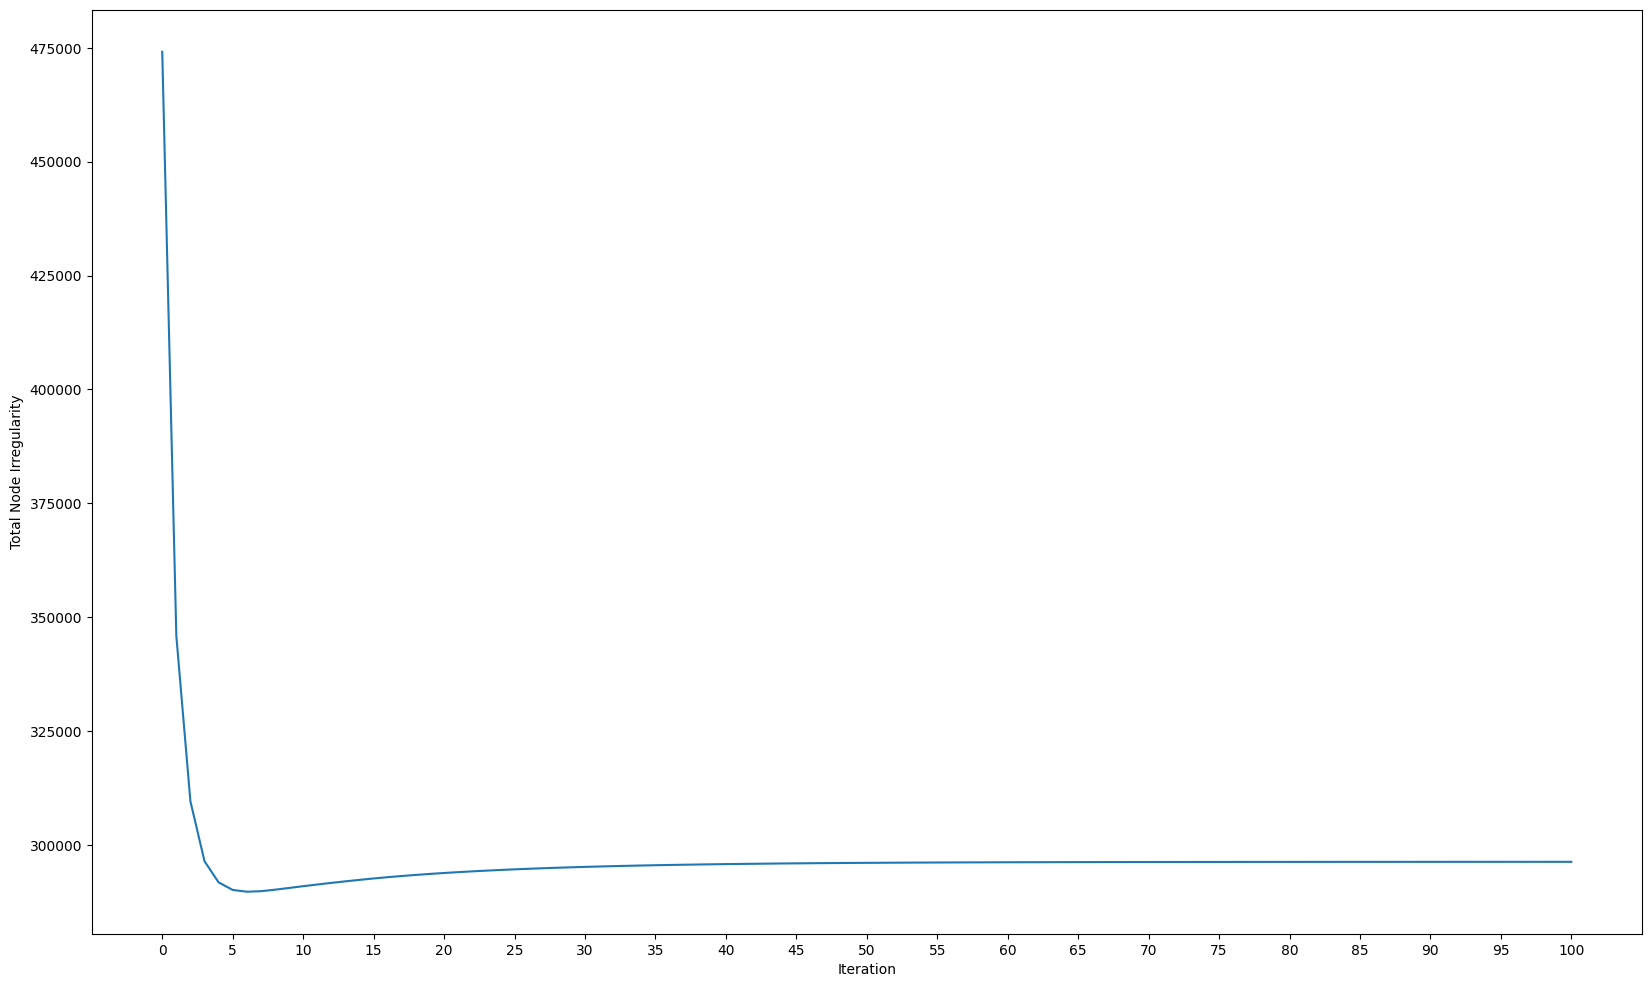

In [18]:

#plot the multipliers and the total node loss
plt.figure(figsize=(20, 12))
#plt.plot(range(len(mults)), mults)
plt.plot(range(len(losses)), losses)
#add labels
plt.xlabel('Iteration')
plt.ylabel('Total Node Irregularity')
#make the tick marks 5 iterations
plt.xticks(np.arange(0, len(losses), 5))
#plt.title('Total Node Irregularity vs Iteration')
plt.show()

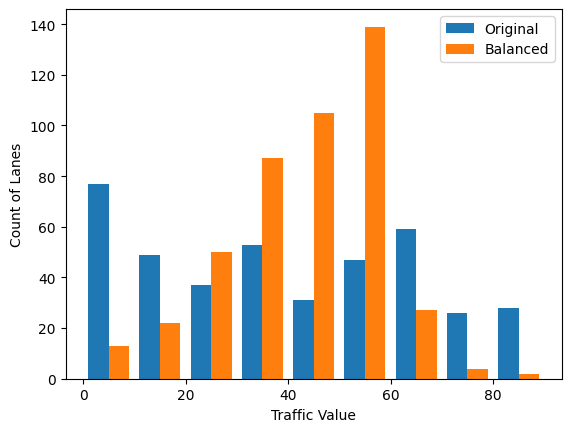

In [19]:
#compare the traffic distribution of the original graph and the balanced graph
#first, make a list of the traffic values of the edges of the original graph
traffic = [np.repeat(G.edges[edge]['traffic'], G.edges[edge]['lanes']) for edge in G.edges]
#then, make a list of the traffic values of the edges of the balanced graph
traffic2 = [np.repeat(G_la.edges[edge]['traffic'], G_la.edges[edge]['lanes']) for edge in G_la.edges]

traffic = np.concatenate(traffic)
traffic2 = np.concatenate(traffic2)

#now, make a histogram with both traffic distributions
plt.hist([traffic, traffic2], label = ['Original', 'Balanced'], bins=np.arange(0, 100, 10))
plt.xlabel('Traffic Value')
plt.ylabel('Count of Lanes')
#plt.title('Traffic Distribution')
plt.legend()
plt.show()

C:\Users\eamor\AppData\Local\Temp\ipykernel_18804\3776034996.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(traffic, shade=True, label='Original')
C:\Users\eamor\AppData\Local\Temp\ipykernel_18804\3776034996.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(traffic2, shade=True, label='Balanced')


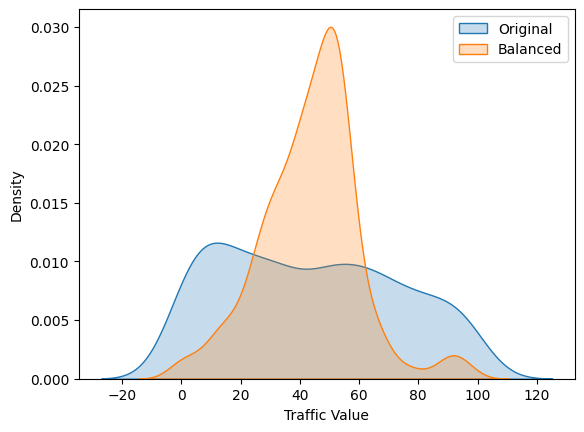

In [20]:
#desnity plot
sns.kdeplot(traffic, shade=True, label='Original')
sns.kdeplot(traffic2, shade=True, label='Balanced')
plt.xlabel('Traffic Value')
plt.ylabel('Density')
#plt.title('Traffic Distribution')
plt.legend()
plt.show()


In [21]:
#describe the traffic distribution of the original graph
print('Original graph')
print('Mean:', np.mean(traffic))
print('Median:', np.median(traffic))
print('Standard deviation:', np.std(traffic))
print('Min:', np.min(traffic))
print('Max:', np.max(traffic))

#describe the traffic distribution of the balanced graph
print('Balanced graph')
print('Mean:', np.mean(traffic2))
print('Median:', np.median(traffic2))
print('Standard deviation:', np.std(traffic2))
print('Min:', np.min(traffic2))
print('Max:', np.max(traffic2))


Original graph
Mean: 43.58202485127093
Median: 41.108111807792675
Standard deviation: 29.609365695029734
Min: -0.8918881922073294
Max: 99.10811180779267
Balanced graph
Mean: 43.58202485127052
Median: 44.820388766093686
Standard deviation: 16.432276089925384
Min: 0.1081118077926706
Max: 96.10811180779267


In [22]:
#Check the stats before and after
print("Original graph vs balanced graph")
print('Total node loss:', round(totalNodeLoss(G)), round(totalNodeLoss(G_la)), round(totalNodeLoss(G_la) / totalNodeLoss(G) * 100, 2), '%')
print('Total edge loss:', round(totalEdgeLoss(G)), round(totalEdgeLoss(G_la)), round(totalEdgeLoss(G_la) / totalEdgeLoss(G) * 100, 2), '%')
print('Total traffic:', round(totalTraffic(G)), round(totalTraffic(G_la)), round(totalTraffic(G_la) / totalTraffic(G) * 100, 2), '%')
#look at the sum of the border traffic
print('Total border traffic:', np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]), np.sum([G_la.nodes[node]['traffic'] for node in G_la.nodes if G_la.nodes[node]['border']]) / np.sum([G.nodes[node]['traffic'] for node in G.nodes if G.nodes[node]['border']]) * 100, '%')

Original graph vs balanced graph
Total node loss: 1076031 296295 27.54 %
Total edge loss: 618621 134253 21.7 %
Total traffic: 20048 20048 100.0 %
Total border traffic: 4779.0 4682.676075241696 97.98443346394006 %


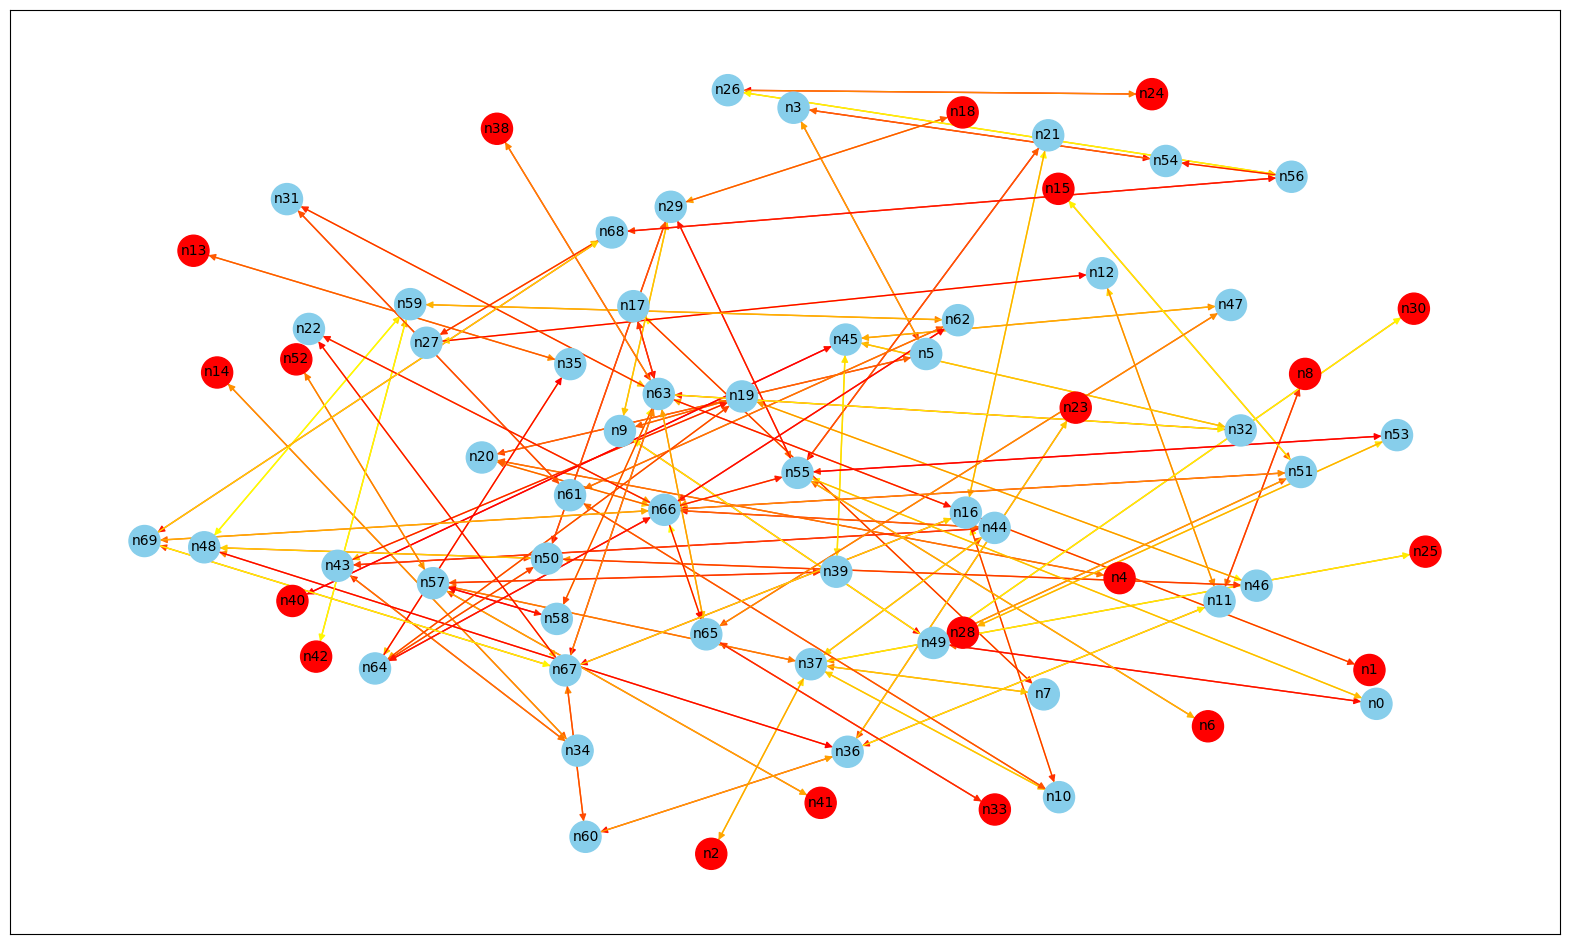

In [23]:
#plot the traffic distribution of the original graph
plt.figure(figsize=(20, 12))
nx.draw_networkx(G, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G.edges[edge]['traffic'] for edge in G.edges], edge_cmap=plt.cm.autumn, pos=pos)

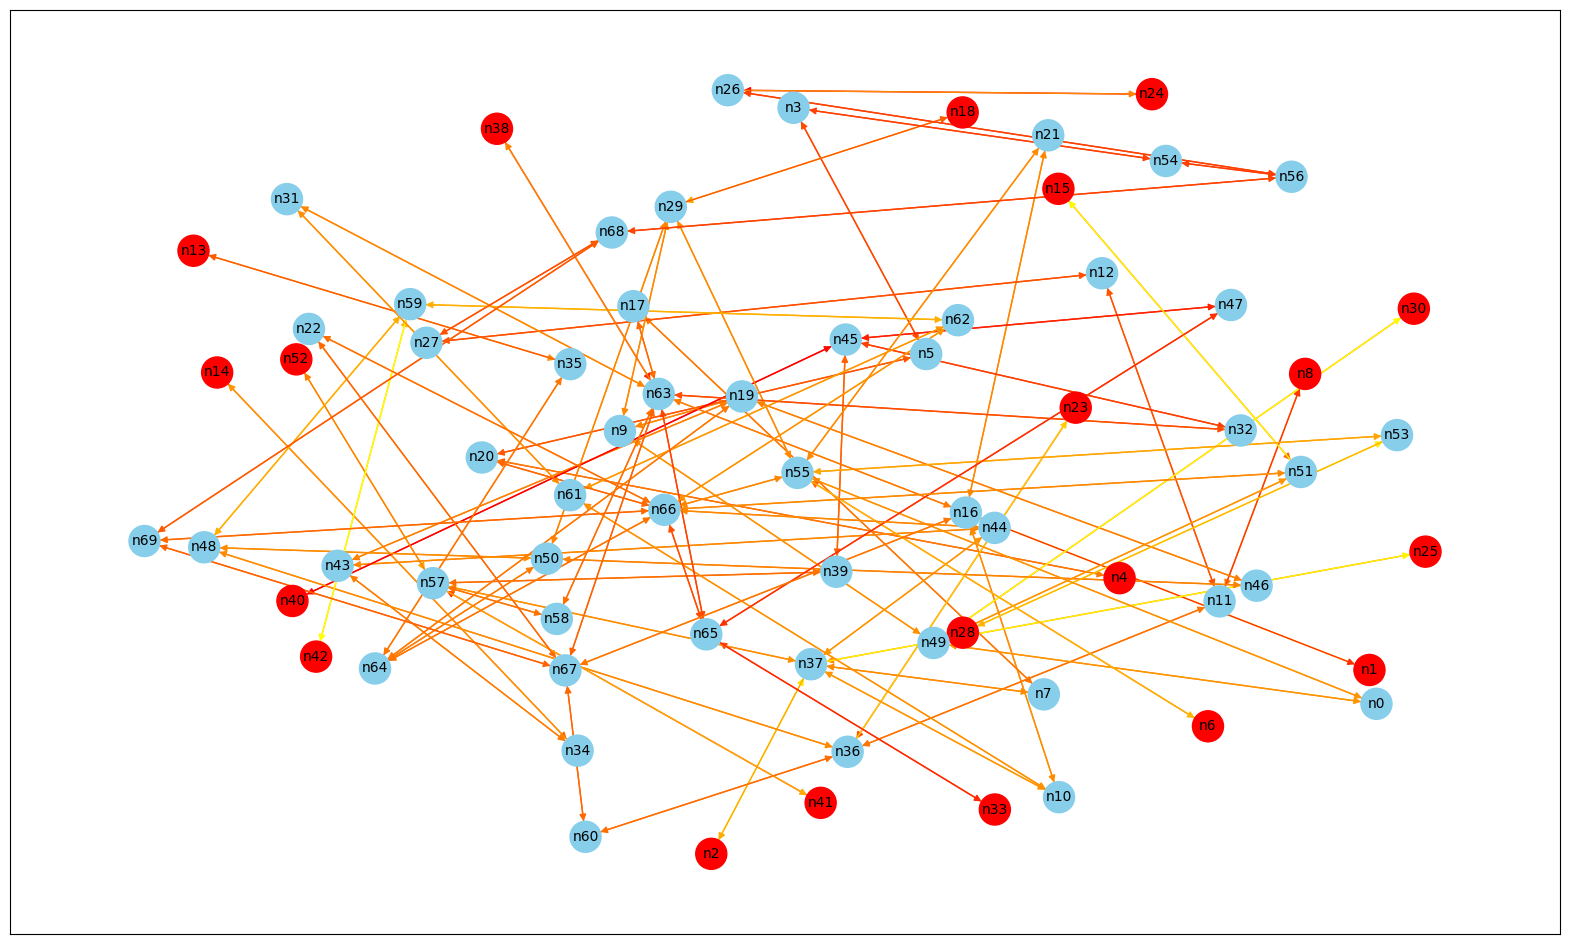

In [25]:
plt.figure(figsize=(20, 12))
nx.draw_networkx(G_la, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G_la, 'border').values()), 'r', 'skyblue'), edge_color=[G_la.edges[edge]['traffic'] for edge in G_la.edges], edge_cmap=plt.cm.autumn, pos=pos)

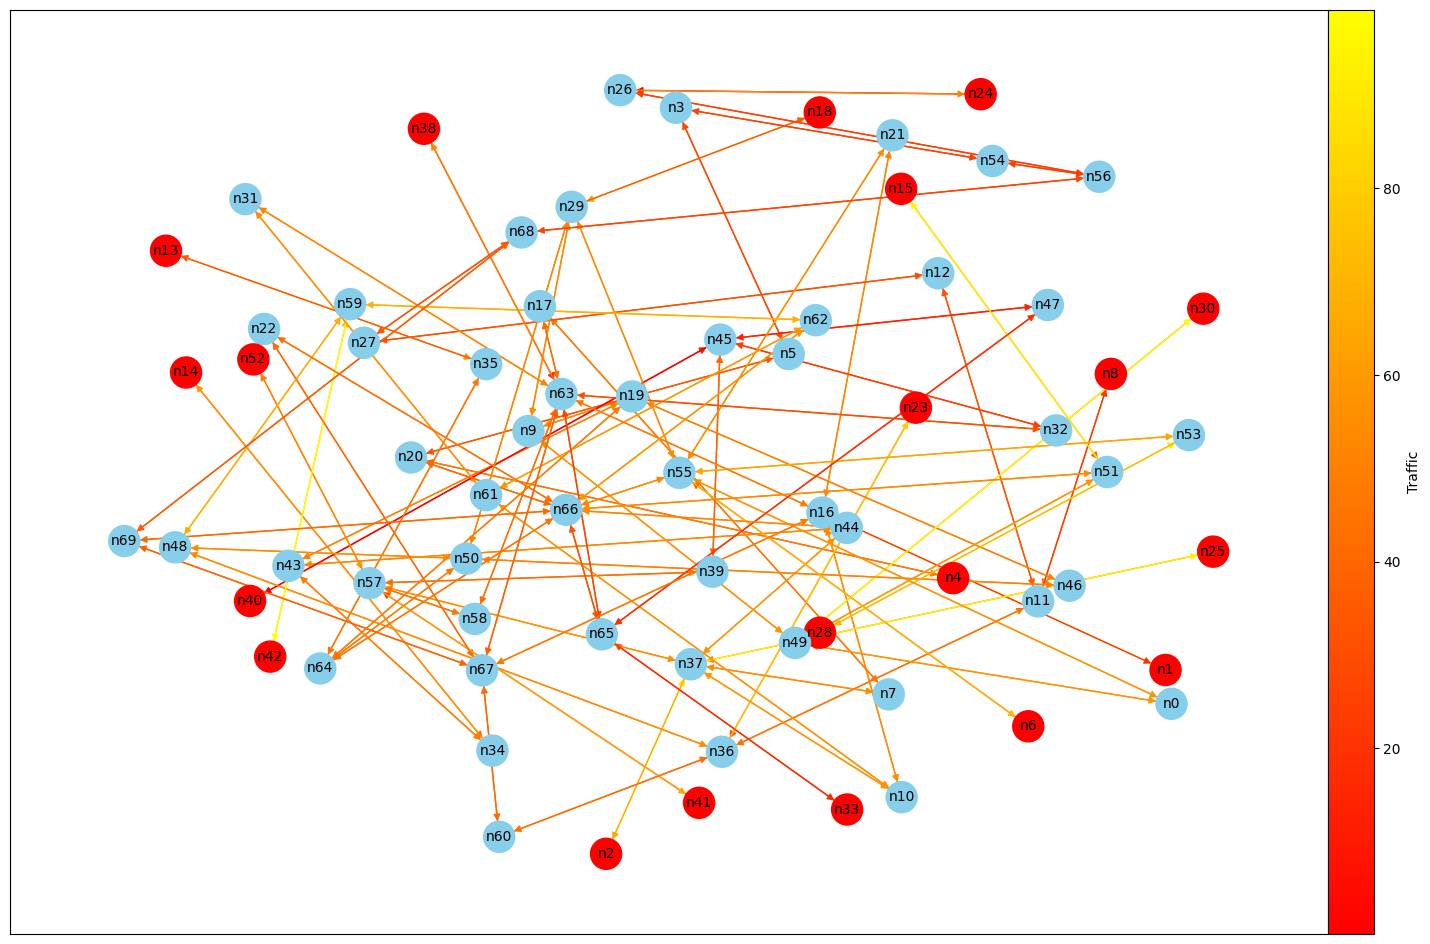

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Assuming you have already defined G and pos

# Draw the graph
plt.figure(figsize=(20, 12))
# Create a colormap that is the second half of the copper colormap
cmap = plt.cm.autumn
# Draw the network with node colors and edge colors
nx.draw_networkx(G_la, with_labels=True, node_size=500, font_size=10, node_color=np.where(list(nx.get_node_attributes(G, 'border').values()), 'r', 'skyblue'), edge_color=[G_la.edges[edge]['traffic'] for edge in G_la.edges], edge_cmap=cmap, pos=pos)

# Get the current Axes instance
ax = plt.gca()

# Create a ScalarMappable to map numerical values to colors in the colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min([G_la.edges[edge]['traffic'] for edge in G_la.edges]), vmax=max([G.edges[edge]['traffic'] for edge in G_la.edges])))

# Empty array to hold the values for the color bar
sm.set_array([])

# Add the color bar at the bottom of the plot
plt.colorbar(sm, ax=ax, label='Traffic', pad=-0, orientation='vertical')

# Show the plot
plt.show()
